In [9]:
#  그냥 복붙
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
    """ 
    Iterates through all the columns of a dataframe and downcasts the data type
     to reduce memory usage. Can also factorize categorical columns to integer dtype.
    """
    def _downcast_numeric(series, allow_categorical=allow_categorical):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            if pd.api.types.is_datetime64_any_dtype(series.dtype):
                return series
            else:
                if allow_categorical:
                    return series
                else:
                    codes, uniques = series.factorize()
                    series = pd.Series(data=codes, index=series.index)
                    series = _downcast_numeric(series)
                    return series
        else:
            series = pd.to_numeric(series, downcast="integer")
        if pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:,col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def shrink_mem_new_cols(matrix, oldcols=None, allow_categorical=False):
    # Calls reduce_mem_usage on columns which have not yet been optimized
    if oldcols is not None:
        newcols = matrix.columns.difference(oldcols)
    else:
        newcols = matrix.columns
    matrix.loc[:,newcols] = reduce_mem_usage(matrix.loc[:,newcols], allow_categorical=allow_categorical)
    oldcols = matrix.columns  # This is used to track which columns have already been downcast
    return matrix, oldcols


def list_if_not(s, dtype=str):
    # Puts a variable in a list if it is not already a list
    if type(s) not in (dtype, list):
        raise TypeError
    if (s != "") & (type(s) is not list):
        s = [s]
    return s

items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")

In [10]:
# EDA 
train.info()
#  0   date            object  dattime 으로 바꾸고 싶다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [11]:
train["date"] 

0          02.01.2013
1          03.01.2013
2          05.01.2013
3          06.01.2013
4          15.01.2013
              ...    
2935844    10.10.2015
2935845    09.10.2015
2935846    14.10.2015
2935847    22.10.2015
2935848    03.10.2015
Name: date, Length: 2935849, dtype: object

In [12]:
# 변환하는 과정  ->
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

train["date"] 

0         2013-01-02
1         2013-01-03
2         2013-01-05
3         2013-01-06
4         2013-01-15
             ...    
2935844   2015-10-10
2935845   2015-10-09
2935846   2015-10-14
2935847   2015-10-22
2935848   2015-10-03
Name: date, Length: 2935849, dtype: datetime64[ns]

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [14]:
# train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})

In [15]:
# train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})을  한 이유


In [16]:
re.match('.*as*','asdasdasd')

NameError: name 're' is not defined

In [ ]:
# 데이터에 특수 문자 제거 하기 
import re


def clean_text(inputString):
    text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', inputString)
    return text_rmv
a = set()
shops_names = shops["shop_name"].apply(clean_text)
shops_id = shops["shop_id"]
# 중복되는 이름 확인 

for i in list(zip(shops_names ,shops_id)):
    for j in list(zip(shops_names ,shops_id)):
        if (re.match('.*'+i[0]+'*.',j[0])) and (i[1]!= j[1]):
            a.add((i , j))
          

In [ ]:
a

{(('Жуковский ул  Чкалова 39м ', 10), ('Жуковский ул  Чкалова 39м²', 11)),
 (('Жуковский ул  Чкалова 39м²', 11), ('Жуковский ул  Чкалова 39м ', 10)),
 (('РостовНаДону ТРК  Мегацентр Горизонт ', 39),
  ('РостовНаДону ТРК  Мегацентр Горизонт  Островной', 40)),
 (('Якутск Орджоникидзе  56', 57), (' Якутск Орджоникидзе  56 фран', 0)),
 (('Якутск ТЦ  Центральный ', 58), (' Якутск ТЦ  Центральный  фран', 1))}

In [ ]:
items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")
cat = pd.read_csv("./data/item_categories.csv")

In [ ]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [ ]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [ ]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [ ]:
#  왜 이상치를 50000 train[train["item_price"] >= 50000] , train[train["item_cnt_day"] >= 1000] 이렇게 하였는가?

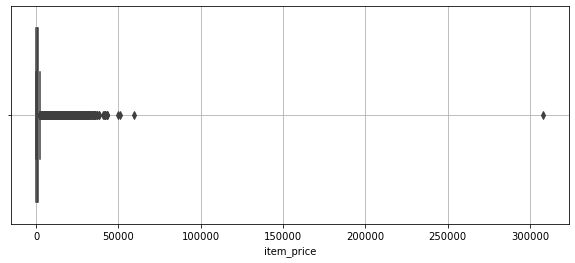

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
sns.boxplot(x=train.item_price)
plt.grid()

In [ ]:
#50000 이상의 이상치가 3개 밖에 안되므로 제거 
len(train[train["item_price"] >= 50000])

3

In [ ]:
len(train)

2935849

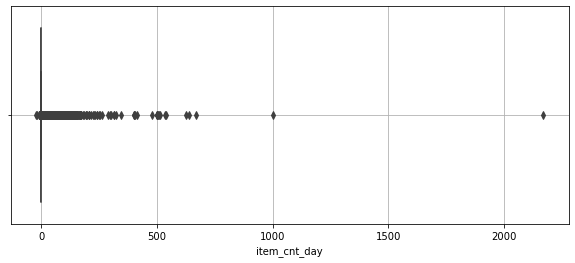

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(x=train.item_cnt_day)
plt.grid()

In [ ]:
#1000 이상의 이상치가 2개 밖에 안되므로 제거 
len(train[train["item_cnt_day"] >= 1000])

2

In [ ]:
train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [ ]:
train['income_per_days'] = train['item_cnt_day'] * train['item_price']
train['income_per_days'] = train['income_per_days']
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})

from sklearn.preprocessing import LabelEncoder
train.sort_values('date',inplace=True)
le = LabelEncoder()
train['date_seq'] = le.fit_transform(train['date'])
le.inverse_transform(train['date_seq'] )



array(['2013-01-01T00:00:00.000000000', '2013-01-01T00:00:00.000000000',
       '2013-01-01T00:00:00.000000000', ...,
       '2015-10-31T00:00:00.000000000', '2015-10-31T00:00:00.000000000',
       '2015-10-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
pivot_for_train = train.pivot_table(index = ['date_block_num','date_seq', 'shop_id','item_id'] , values='income_per_days',aggfunc= 'sum')
pivot_for_train.sort_index(level = 'date_seq', inplace=True)


In [ ]:
train_added_cat  = pd.merge(left= train , right = items , left_on = 'item_id' , right_on='item_id' , how = 'left')

In [ ]:
del train_added_cat['item_name']

In [ ]:
train_added_cat
pivot_for_train = train_added_cat.pivot_table(index = ['date_block_num','date_seq', 'shop_id','item_category_id','item_id'] , values='income_per_days',aggfunc= 'sum')

In [ ]:
pivot_for_train[pivot_for_train.index.names == 'date_block_num']

KeyError: False

In [ ]:
x = train.iloc[: ,1:-1 ]
y = train.iloc[: ,-1 ]

from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test   = \
train_test_split (x , y  , test_size= 0.3  ,random_state=42)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

model.score(x_test,y_test)

price_list = model.predict(x_test)

from sklearn.metrics import r2_score 
# 결정계수 (r_square) >> 모형의 설명력
r2_score(y_test, price_list) # 실제값 예츠값

model.coef_

train.columns[1:-1]

feature_importance_lr = pd.DataFrame(data=np.c_[train.columns[1:-1],
                                                model.coef_],
                                     columns=["변수명", "상관계수"])
feature_importance_lr.sort_values("상관계수", ascending=False, inplace=True)

feature_importance_lr

,변수명,상관계수
4,item_cnt_day,1059.788789
3,item_price,1.397893
2,item_id,-0.012564
1,shop_id,-0.041643
0,date_block_num,-2.646936


NameError: name 'train' is not defined